In [1]:
# default_exp disparity

# Disparity

In [2]:
# export
import re
import time
from pathlib import Path

import numba
import torch
import numpy as np
import matplotlib.pyplot as plt

from camera_calib.utils import *

# Utilities

In [3]:
def _parse_name(name_img):
    match = re.match(r'''SERIAL_(?P<serial>.*)_
                         DATETIME_(?P<date>.*)_
                         CAM_(?P<cam>.*)_
                         FRAMEID_(?P<frameid>.*)_
                         COUNTER_(?P<counter>.*).png''', 
                     name_img, 
                     re.VERBOSE)
    return match.groupdict()

In [4]:
def _get_imgs(dir_imgs):
    imgs = []
    for file_img in dir_imgs.glob('*.png'):
        dict_group = _parse_name(file_img.name)
        img = api.File16bitImg(file_img)
        img.idx_cam = int(dict_group['cam'])-1
        img.idx_cb  = int(dict_group['counter'])-1
        imgs.append(img)
    return imgs

In [5]:
def _print_imgs(imgs): 
    for img in imgs: print(f'{img.name} - cam: {img.idx_cam} - cb: {img.idx_cb}')

# Compute disparity map

## Calibrate

In [6]:
import camera_calib.api as api

In [7]:
imgs = _get_imgs(Path('data/calib'))
_print_imgs(imgs)

SERIAL_19061245_DATETIME_2020-08-16-16:58:39-927381_CAM_1_FRAMEID_0_COUNTER_1 - cam: 0 - cb: 0
SERIAL_16276941_DATETIME_2020-08-16-16:58:53-756240_CAM_2_FRAMEID_0_COUNTER_2 - cam: 1 - cb: 1
SERIAL_16276941_DATETIME_2020-08-16-16:58:39-927424_CAM_2_FRAMEID_0_COUNTER_1 - cam: 1 - cb: 0
SERIAL_16276941_DATETIME_2020-08-16-16:59:05-367688_CAM_2_FRAMEID_0_COUNTER_3 - cam: 1 - cb: 2
SERIAL_19061245_DATETIME_2020-08-16-16:59:59-403047_CAM_1_FRAMEID_0_COUNTER_4 - cam: 0 - cb: 3
SERIAL_16276941_DATETIME_2020-08-16-17:00:14-283298_CAM_2_FRAMEID_0_COUNTER_5 - cam: 1 - cb: 4
SERIAL_19061245_DATETIME_2020-08-16-16:58:53-756222_CAM_1_FRAMEID_0_COUNTER_2 - cam: 0 - cb: 1
SERIAL_16276941_DATETIME_2020-08-16-16:59:59-403092_CAM_2_FRAMEID_0_COUNTER_4 - cam: 1 - cb: 3
SERIAL_19061245_DATETIME_2020-08-16-16:59:05-367645_CAM_1_FRAMEID_0_COUNTER_3 - cam: 0 - cb: 2
SERIAL_19061245_DATETIME_2020-08-16-17:00:14-283252_CAM_1_FRAMEID_0_COUNTER_5 - cam: 0 - cb: 4


In [8]:
h_cb = 50.8
w_cb = 50.8
h_f = 42.672
w_f = 42.672
num_c_h = 16
num_c_w = 16
spacing_c = 2.032
cb_geom = api.CbGeom(h_cb, w_cb,
                     api.CpCSRGrid(num_c_h, num_c_w, spacing_c),
                     api.FmCFPGrid(h_f, w_f))

In [9]:
file_model = Path('models/dot_vision_checker.pth')
detector = api.DotVisionCheckerDLDetector(file_model)

In [10]:
refiner = api.OpenCVCheckerRefiner(hw_min=5, hw_max=15, cutoff_it=20, cutoff_norm=1e-3)

In [11]:
calib = api.multi_calib(imgs, cb_geom, detector, refiner)

Refining control points for: SERIAL_19061245_DATETIME_2020-08-16-16:58:39-927381_CAM_1_FRAMEID_0_COUNTER_1...
Refining control points for: SERIAL_19061245_DATETIME_2020-08-16-16:59:59-403047_CAM_1_FRAMEID_0_COUNTER_4...
Refining control points for: SERIAL_19061245_DATETIME_2020-08-16-16:58:53-756222_CAM_1_FRAMEID_0_COUNTER_2...
Refining control points for: SERIAL_19061245_DATETIME_2020-08-16-16:59:05-367645_CAM_1_FRAMEID_0_COUNTER_3...
Refining control points for: SERIAL_19061245_DATETIME_2020-08-16-17:00:14-283252_CAM_1_FRAMEID_0_COUNTER_5...
Refining single parameters...
 - Iteration: 000 - Norm:    0.05166 - Loss:   40.43536
 - Iteration: 001 - Norm:    0.05871 - Loss:   27.05900
 - Iteration: 002 - Norm:    0.10641 - Loss:   16.14479
 - Iteration: 003 - Norm:    0.52404 - Loss:    9.86104
 - Iteration: 004 - Norm:    0.70472 - Loss:    5.50705
 - Iteration: 005 - Norm:    0.15078 - Loss:    5.39712
 - Iteration: 006 - Norm:    0.02470 - Loss:    5.38315
 - Iteration: 007 - Norm:   

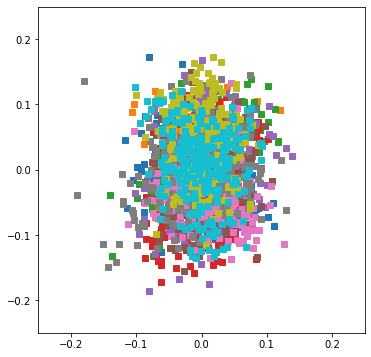

In [12]:
api.plot_residuals(calib);

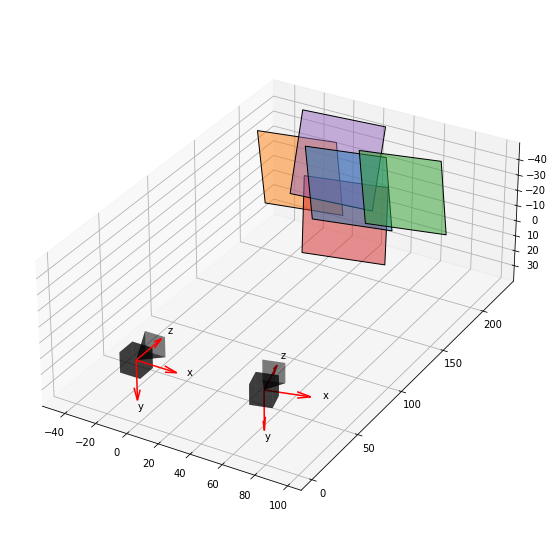

In [13]:
api.plot_extrinsics(calib);

In [14]:
api.save(calib, 'data/calib/calib.pth')

Freeze above and just load

In [7]:
calib = api.load('data/calib/calib.pth')

## Rectify

In [8]:
from image_rect import image_rect

In [9]:
imgs = _get_imgs(Path('data/scene1'))
_print_imgs(imgs)

SERIAL_19061245_DATETIME_2020-08-16-17:05:28-278345_CAM_1_FRAMEID_0_COUNTER_1 - cam: 0 - cb: 0
SERIAL_16276941_DATETIME_2020-08-16-17:05:28-278389_CAM_2_FRAMEID_0_COUNTER_1 - cam: 1 - cb: 0


In [10]:
[img1] = [img for img in imgs if img.idx_cam == 0]
[img2] = [img for img in imgs if img.idx_cam == 1]
img1.name, img2.name

('SERIAL_19061245_DATETIME_2020-08-16-17:05:28-278345_CAM_1_FRAMEID_0_COUNTER_1',
 'SERIAL_16276941_DATETIME_2020-08-16-17:05:28-278389_CAM_2_FRAMEID_0_COUNTER_1')

In [11]:
rect = image_rect.rectify(calib)

In [12]:
with torch.no_grad():
    arr1_r = image_rect.rect_img(img1, rect)
    arr2_r = image_rect.rect_img(img2, rect)

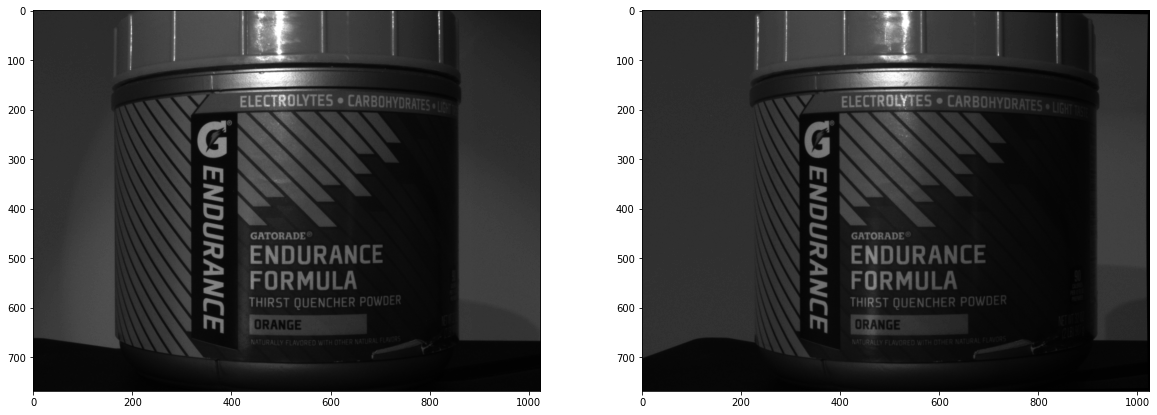

In [13]:
_, axs = plt.subplots(1, 2, figsize=(20,15))
axs[0].imshow(arr1_r, cmap='gray')
axs[1].imshow(arr2_r, cmap='gray')

## Disparity

Do initial resize to make processing faster; also note that I'm doing the rest in numba/numpy since a lot of nested for loops are involved.

NOTE: numba does not yet support classes with inheritance, so I've used functions as first class citizens for now

In [14]:
arr1, arr2 = [imresize(torch2np(arr), shape(arr)/4) for arr in [arr1_r, arr2_r]]

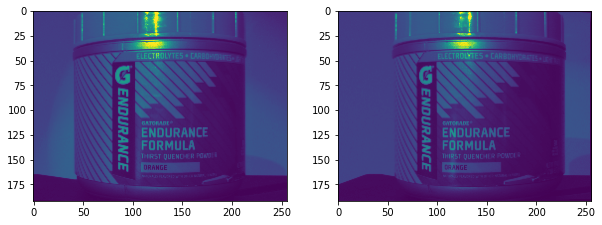

In [15]:
_, axs = plt.subplots(1, 2, figsize=(10,10))
for arr, ax in zip([arr1, arr2], axs): ax.imshow(arr)

### Basic block matching

In [16]:
# export
@numba.jit(nopython=True)
def SAD(arr1, arr2):
    l = 0
    for i in range(arr1.shape[0]):
        for j in range(arr2.shape[1]):
            l += abs(arr1[i,j] - arr2[i,j])
    return l

`rect_loss_p` will compute the loss for a single point and store the losses in a buffer

In [17]:
# export
@numba.jit(nopython=True)
def rect_loss_p(arr1, arr2, x, y, hw, min_disp, max_disp, loss, buf_loss):
    h_arr, w_arr = arr1.shape[0], arr1.shape[1]

    l_t, t_t, r_t, b_t = max(x-hw, 0), max(y-hw, 0), min(x+hw, w_arr-1), min(y+hw, h_arr-1)
    h_t, w_t = b_t-t_t+1, r_t-l_t+1
    for j in range(max(-l_t, min_disp), min(w_arr-r_t, max_disp+1)):
        buf_loss[j-min_disp] = loss(arr1[t_t:t_t+h_t, l_t:l_t+w_t], arr2[t_t:t_t+h_t, j+l_t:j+l_t+w_t])

`argmin_int` is the integer argument minimum; `int` suffix is only used to distinguish between subpixel minimum, which is used later.

In [18]:
# export
@numba.jit(nopython=True)
def argmin_int(arr): return np.argmin(arr)

Test out getting the loss for an example point

In [19]:
def _debug_rect_loss_p(x, y):
    buf_p = np.full(max_disp-min_disp+1, np.inf)
    rect_loss_p(arr1, arr2, x, y, hw, min_disp, max_disp, loss, buf_p)
    d = argmin(buf_p) + min_disp
    _, axs = plt.subplots(1, 2, figsize=(10,10))
    axs[0].imshow(arr1)
    axs[0].plot(x, y, 'rs')
    axs[1].imshow(arr2)
    axs[1].plot(x+d, y, 'rs')

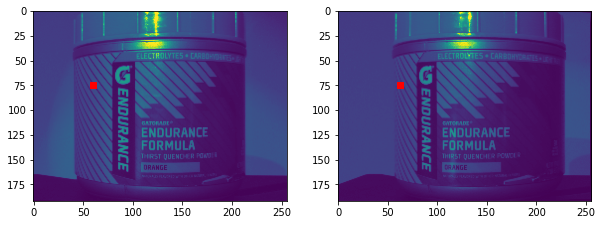

In [20]:
hw = 15
min_disp = -15
max_disp =  15
loss = SAD
argmin = argmin_int
_debug_rect_loss_p(x=60, y=75)

`rect_loss_l` will compute the loss for an entire line. Note that an initial disparity map guess can also be input; if this is the case, then the disparity range will be centered around this disparity value instead of zero.

In [21]:
# export
@numba.jit(nopython=True)
def rect_loss_l(arr1, arr2, y, hw, r_disp, loss, arr_disp_init=None):
    h_arr, w_arr = arr1.shape[0], arr1.shape[1]

    buff_loss = np.full((w_arr, r_disp[1]-r_disp[0]+1), np.inf)
    for i in range(w_arr):
        disp_init = 0 if arr_disp_init is None else arr_disp_init[y, i]
        min_disp, max_disp = [disp + disp_init for disp in r_disp]
        rect_loss_p(arr1, arr2, i, y, hw, min_disp, max_disp, loss, buff_loss[i, :])
    return buff_loss

In [22]:
def _debug_rect_loss_l(y):
    buf_loss = rect_loss_l(arr1, arr2, y, hw, r_disp, loss)
    _, ax = plt.subplots(1, 1, figsize=(10,10))
    ax.imshow(buf_loss.T)
    return buf_loss

In [23]:
r_disp = (-15, 15)

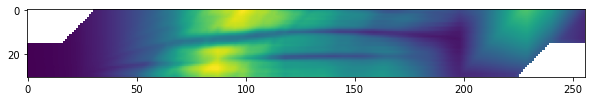

In [24]:
_debug_rect_loss_l(60);

Note in the above (transposed) loss buffer, the `argmin` will be done column-wise, which could be a problem near column ~125 since there are two minima there.

`min_path_int` will compute path from left to right of transposed loss buffer using the minimum value in each column.

In [25]:
# export
@numba.jit(nopython=True)
def min_path_int(arr_loss, buf_path):
    for i in range(len(arr_loss)):
        buf_path[i] = argmin_int(arr_loss[i, :])

`rect_match_arr` will compute a disparity map. It takes an input `min_path` function which, when given a loss buffer, will compute the best path across it; this will make more sense when we use dynamic programming. `arr_disp_init` is an initial guess for the disparity map; this will make more sense when we do the image pyramids. 

Note that this seems to be the level where multi-threading makes sense; it's not too fine grained where overhead will slow things down and it's not to grainular such that a single thread can cause a long delay.

In [26]:
# export
@numba.jit(nopython=True, parallel=True)
def rect_match_arr(arr1, arr2, hw, r_disp, loss, min_path, arr_disp_init=None):
    h_arr, w_arr = arr1.shape[0], arr1.shape[1]
    
    arr_disp = np.empty((h_arr, w_arr))
    for i in numba.prange(h_arr):
        buf_loss = rect_loss_l(arr1, arr2, i, hw, r_disp, loss, arr_disp_init)
        min_path(buf_loss, arr_disp[i,:]) # Note that initial disparity and range offsets need to be applied
        if arr_disp_init is not None: arr_disp[i,:] += arr_disp_init[i,:]
        arr_disp[i,:] += r_disp[0]                                        
    return arr_disp

In [27]:
arr_disp = rect_match_arr(arr1, arr2, hw, r_disp, loss, min_path_int)

Do it again so numba will compile and run faster.

In [28]:
arr_disp = rect_match_arr(arr1, arr2, hw, r_disp, loss, min_path_int)

~200 ms is not bad. This could be realtime-ish performance for this image resolution.

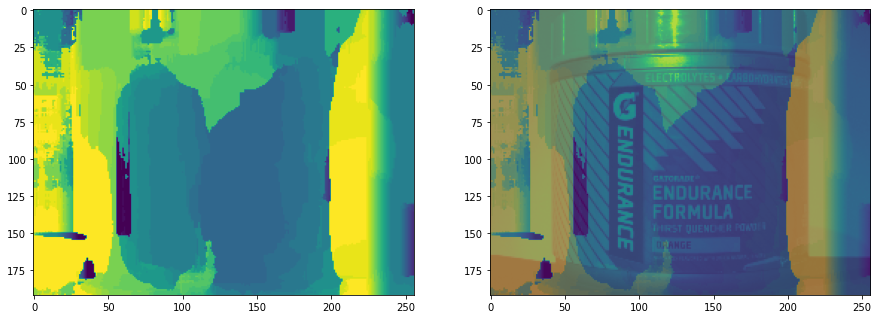

In [29]:
_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(arr_disp, vmin=min_disp, vmax=max_disp)
axs[1].imshow(arr1)
axs[1].imshow(arr_disp, vmin=min_disp, vmax=max_disp, alpha=0.5)

As to be expected this doesn't look great; lets debug some problem areas

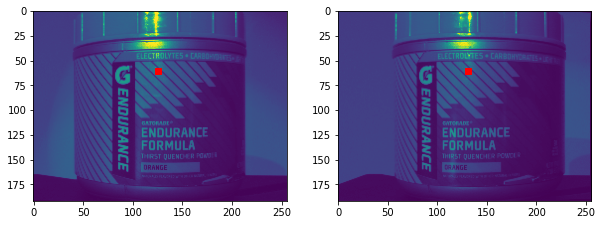

In [30]:
_debug_rect_loss_p(125, 60)

There is confusion with similar patterns. Note the found point on the right image is 3 stripes other rather than 2 on the left image.

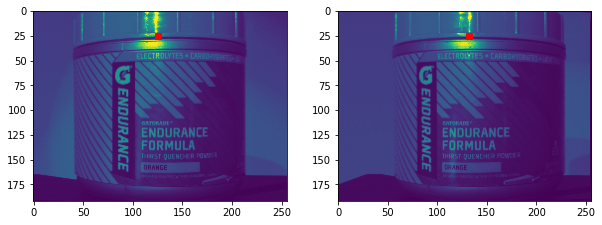

In [31]:
_debug_rect_loss_p(125, 25)

Glare causes an issue; note the point on the right image is aligned to the glare instead of where it should be

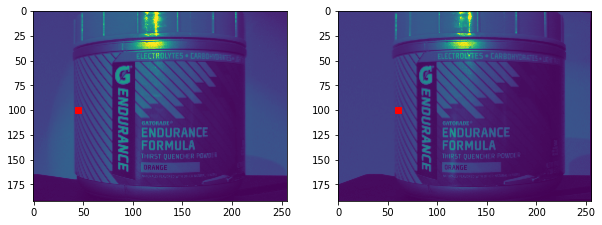

In [32]:
_debug_rect_loss_p(45, 100)

This is actually wrong since the left part of the object is not visible to the right camera. It's more aligned to the side of the object rather than its actual location.

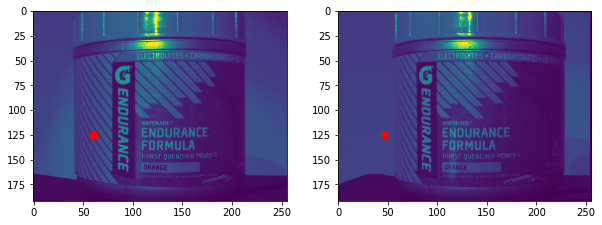

In [33]:
_debug_rect_loss_p(60, 125)

This might be due to the fact that sub images are not normalized (mean subtracted and divided by std-dev) before being compared.

### Subpixel block matching

`argmin_sub` uses a single newton's iteration to find the root of the derivate (i.e. the minima). The update is the first derivative divided by the second derivative at the integer minimum location.

In [34]:
# export
@numba.jit(nopython=True)
def argmin_sub(arr):
    idx_min = argmin_int(arr)
    if 1 <= idx_min <= len(arr)-2:
        delta_idx = ((arr[idx_min+1]-arr[idx_min-1])/2)/(arr[idx_min+1]-2*arr[idx_min]+arr[idx_min-1])
        if np.isnan(delta_idx): delta_idx = 0
        if delta_idx < -1:      delta_idx = -1
        if delta_idx >  1:      delta_idx =  1
        idx_min = idx_min - delta_idx
    return idx_min

In [35]:
# export
@numba.jit(nopython=True)
def min_path_sub(arr_loss, buf_path):
    for i in range(len(arr_loss)):
        buf_path[i] = argmin_sub(arr_loss[i, :])

In [36]:
arr_disp = rect_match_arr(arr1, arr2, hw, r_disp, loss, min_path_sub)

In [37]:
arr_disp = rect_match_arr(arr1, arr2, hw, r_disp, loss, min_path_sub)

Again, around ~200 ms, the subpixel stuff doesn't add much overhead

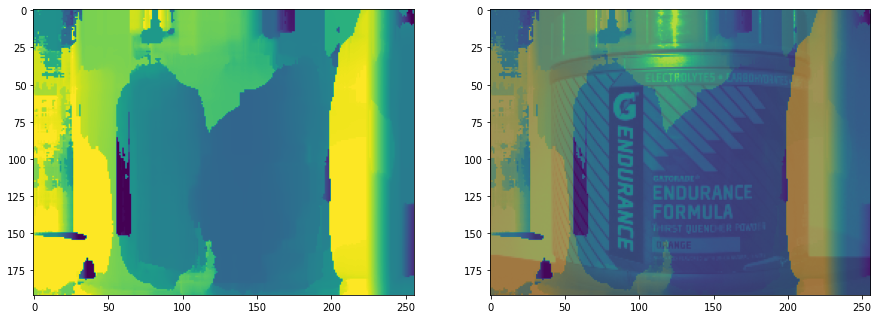

In [38]:
_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(arr_disp, vmin=-15, vmax=15)
axs[1].imshow(arr1)
axs[1].imshow(arr_disp, vmin=-15, vmax=15, alpha=0.5)

Looks smoother near the center of the object.

### Dynamic programming

The goal of dynamic programming is to find the shortest path from left to right in the following array:

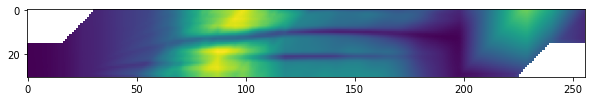

In [39]:
arr_loss = _debug_rect_loss_l(75)

But with an added smoothness contraint. This will be in the form of a penalty for going "up" and "down" and also a max change between neighboring columns. The hope is that, in the above, the path taken will not skip down near the 125 row, but will instead continue smoothly above it, because doing so would incur a pentalty.

In [40]:
# export
@numba.jit(nopython=True)
def _min_path_int_dp(arr_loss, buf_path, r_disp, max_change, cost_disp):
    buf_route     = np.zeros(arr_loss.shape)
    buf_move      = np.empty((2*max_change+1, r_disp[1]-r_disp[0]+1))
    but_loss_prev = arr_loss[-1].copy()
    for i in range(len(arr_loss)-1, -1, -1):
        # Get total cost of each move
        buf_move[:] = np.inf
        for j in range(-max_change, max_change+1):
            idx_minc, idx_maxc = max( j,0), min(arr_loss.shape[1]+j,arr_loss.shape[1])
            idx_minm, idx_maxm = max(-j,0), min(arr_loss.shape[1]-j,arr_loss.shape[1])
            buf_move[j+max_change, idx_minm:idx_maxm] = but_loss_prev[idx_minc:idx_maxc] + abs(j)*cost_disp
        # Get optimal move and store it
        for j in range(buf_move.shape[1]):
            idx_min = np.argmin(buf_move[:,j])
            buf_route[i,j] = idx_min - max_change
            but_loss_prev[j] = arr_loss[i,j] + buf_move[idx_min, j] # loss = previous loss + optimal move
    # Gather path
    buf_path[0] = np.argmin(but_loss_prev)
    for i in range(1, len(buf_route)):
        buf_path[i] = buf_path[i-1] + buf_route[i-1, int(buf_path[i-1])]

Numba does not support lambdas yet, so use factory function as per documentation

In [41]:
# export
def make_min_path_int_dp(r_disp, max_change, cost_disp):
    @numba.jit(nopython=True)
    def min_path(arr_loss, buf_path):
        return _min_path_int_dp(arr_loss, buf_path, r_disp, max_change, cost_disp)
    return min_path

In [42]:
cost_disp  = 2
max_change = 3

In [43]:
min_path_int_dp = make_min_path_int_dp(r_disp, max_change, cost_disp)

In [44]:
def _debug_min_path(min_path):
    buf_path = np.empty(arr_loss.shape[0])
    min_path(arr_loss, buf_path)
    _, ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(arr_loss.T)
    plt.plot(buf_path, '-r')

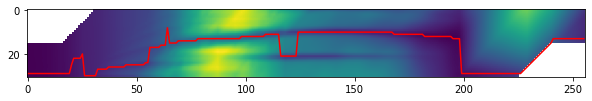

In [45]:
_debug_min_path(min_path_int)

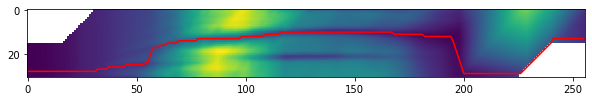

In [46]:
_debug_min_path(min_path_int_dp)

Dynamic programming punishes the jump near 125 and prevents it from happening... cool

In [47]:
arr_disp = rect_match_arr(arr1, arr2, hw, r_disp, loss, min_path_int_dp)

In [48]:
arr_disp = rect_match_arr(arr1, arr2, hw, r_disp, loss, min_path_int_dp)

Again, ~200 ms, not bad.

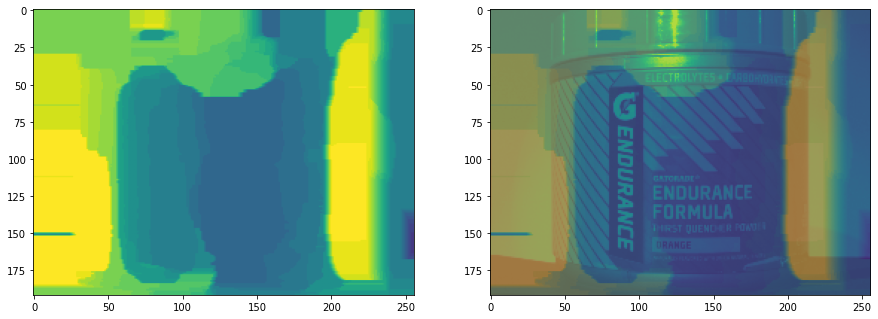

In [49]:
_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(arr_disp, vmin=-15, vmax=15)
axs[1].imshow(arr1)
axs[1].imshow(arr_disp, vmin=-15, vmax=15, alpha=0.5)

Definitely much smoother. The glare still causes problems though.

### Sub pixel dynamic programming

I just basically replaced all `argmin`s with `argmin_sub` and also replaced indexing with `interp`. This assumes smoothness between adjacent optimal paths and im not sure if its strictly correct, but it seems to work.

In [50]:
# export
@numba.jit(nopython=True)
def interp(arr, idx):
    if idx < 0 or len(arr)-1 < idx: val = np.nan
    else:
        idx_f = np.floor(idx)
        if idx == idx_f:    val = arr[int(idx_f)]
        else:               val = (idx_f+1-idx)*arr[int(idx_f)] + (idx-idx_f)*arr[int(idx_f)+1]
    return val

In [51]:
arr = np.array([1,2,3])
assert_allclose(np.isnan(interp(arr, -0.5)), True)
assert_allclose(         interp(arr,  0.0),  1.0)
assert_allclose(         interp(arr,  0.5),  1.5)
assert_allclose(         interp(arr,  1.0),  2.0)
assert_allclose(         interp(arr,  1.5),  2.5)
assert_allclose(         interp(arr,  2.0),  3.0)
assert_allclose(np.isnan(interp(arr,  2.5)), True)

In [52]:
# export
@numba.jit(nopython=True)
def _min_path_sub_dp(arr_loss, buf_path, r_disp, max_change, cost_disp):
    buf_route     = np.zeros(arr_loss.shape)
    buf_move      = np.empty((2*max_change+1, r_disp[1]-r_disp[0]+1))
    buf_cost_prev = arr_loss[-1].copy()
    for i in range(len(arr_loss)-1, -1, -1):
        # Get total cost of each move
        buf_move[:] = np.inf
        for j in range(-max_change, max_change+1):
            idx_minc, idx_maxc = max( j,0), min(arr_loss.shape[1]+j,arr_loss.shape[1])
            idx_minm, idx_maxm = max(-j,0), min(arr_loss.shape[1]-j,arr_loss.shape[1])
            buf_move[j+max_change, idx_minm:idx_maxm] = buf_cost_prev[idx_minc:idx_maxc] + abs(j)*cost_disp
        # Get optimal move and store it
        for j in range(buf_move.shape[1]):
            idx_min = argmin_sub(buf_move[:,j])
            buf_route[i,j] = idx_min - max_change
            buf_cost_prev[j] = arr_loss[i,j] + interp(buf_move[:, j], idx_min)
    # Gather path                       
    buf_path[0] = argmin_sub(buf_cost_prev)
    for i in range(1, len(buf_route)):
        buf_path[i] = buf_path[i-1] + interp(buf_route[i-1, :], buf_path[i-1])

In [53]:
# export
def make_min_path_sub_dp(r_disp, max_change, cost_disp):
    @numba.jit(nopython=True)
    def min_path(arr_loss, buf_path):
        return _min_path_sub_dp(arr_loss, buf_path, r_disp, max_change, cost_disp)
    return min_path

In [54]:
min_path_sub_dp = make_min_path_sub_dp(r_disp, max_change, cost_disp)

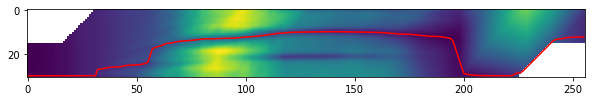

In [55]:
_debug_min_path(min_path_sub_dp)

It's smooth now

In [56]:
arr_disp = rect_match_arr(arr1, arr2, hw, r_disp, loss, min_path_sub_dp)

In [57]:
arr_disp = rect_match_arr(arr1, arr2, hw, r_disp, loss, min_path_sub_dp)

Still ~200 ms

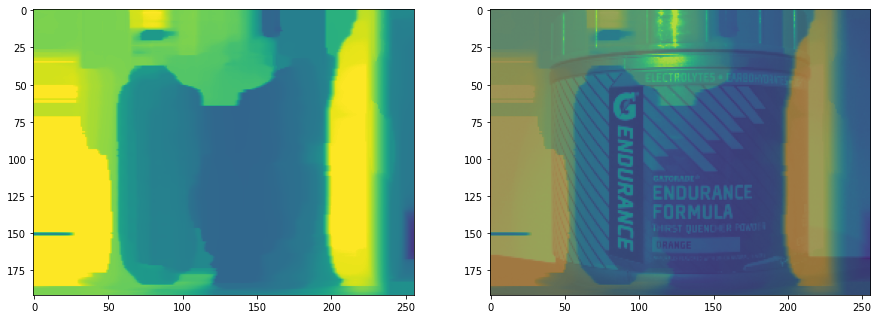

In [58]:
_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(arr_disp, vmin=-15, vmax=15)
axs[1].imshow(arr1)
axs[1].imshow(arr_disp, vmin=-15, vmax=15, alpha=0.5)

It's a little bit different from the integer version, but overall it looks similar and is smoother

### Image pyramid

Try using an image pyramid with "telescoping" search. Note that I've kept the window size the same for each level. In the most reduced image, it will use a proportionally larger window to get the overall translation correct, then in larger images, the proportionally smaller window will localize better.

In [59]:
# export
def rect_match_pyr(arr1, arr2, hw, r_disp, loss, min_path, steps=3):
    if not np.all(shape(arr1) % 2**steps == 0): raise RuntimeError('Shape must be divisible by 2^steps')

    def _get_pyr(arr):
        arr_pyr = [arr]
        for idx in range(steps-1): 
            arr_pyr.append(imresize(arr_pyr[-1], shape(arr_pyr[-1])/2))
        return arr_pyr
    arr1_pyr, arr2_pyr = [_get_pyr(arr) for arr in [arr1, arr2]]

    arr_disp = None
    for idx in range(steps-1,-1,-1):
        arr1, arr2 = arr1_pyr[idx], arr2_pyr[idx]
        if arr_disp is not None:
            arr_disp = imresize(2*arr_disp, 2*shape(arr_disp)) # Remember to multiply disparities by 2
            arr_disp = np.round(arr_disp).astype(np.long)      # Must be integer
        arr_disp = rect_match_arr(arr1, arr2, hw, r_disp, loss, min_path, arr_disp)
    return arr_disp

In [60]:
hw = 15
max_change = 3
r_disp = (-5,5)

In [61]:
arr_disp = rect_match_pyr(arr1, arr2, hw, r_disp, loss, min_path_sub)

In [62]:
arr_disp = rect_match_pyr(arr1, arr2, hw, r_disp, loss, min_path_sub)

~100 ms, could probably optimize more but its fast

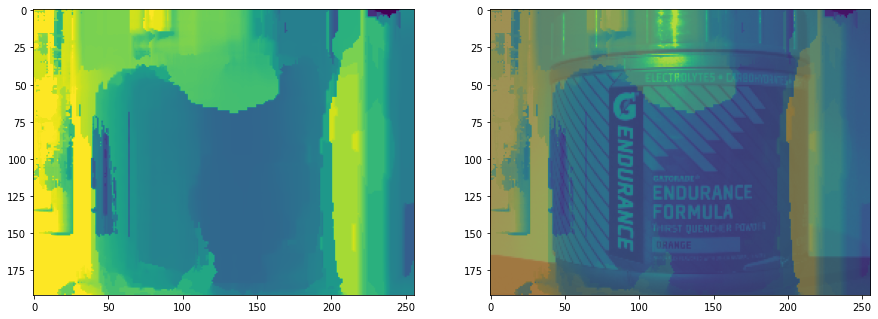

In [63]:
_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(arr_disp, vmin=-15, vmax=15)
axs[1].imshow(arr1)
axs[1].imshow(arr_disp, vmin=-15, vmax=15, alpha=0.5)

In [64]:
min_path_sub_dp = make_min_path_sub_dp(r_disp, max_change, cost_disp)

In [65]:
arr_disp = rect_match_pyr(arr1, arr2, hw, r_disp, loss, min_path_sub_dp)

In [66]:
arr_disp = rect_match_pyr(arr1, arr2, hw, r_disp, loss, min_path_sub_dp)

~140 ms, a little slower but still pretty fast

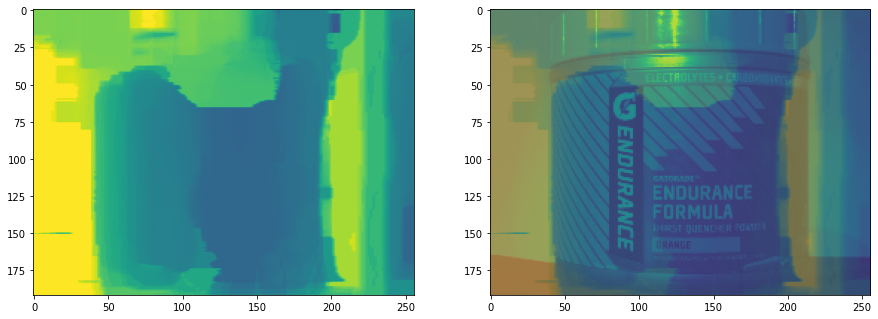

In [67]:
_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(arr_disp, vmin=-15, vmax=15)
axs[1].imshow(arr1)
axs[1].imshow(arr_disp, vmin=-15, vmax=15, alpha=0.5)

# API

Use a class here because every time `min_path_*_dp` is instantiated it seems to make numba recompile, so cache it in the class to make each call fast.

In [68]:
# export
class RectMatch:
    def __init__(self, type_min_path, hw=15, r_disp=(-5,5), loss=SAD, steps=3, max_change=3, cost_disp=2):
        if   type_min_path == 'int':    min_path = min_path_int
        elif type_min_path == 'sub':    min_path = min_path_sub
        elif type_min_path == 'int_dp': min_path = make_min_path_int_dp(r_disp, max_change, cost_disp)
        elif type_min_path == 'sub_dp': min_path = make_min_path_sub_dp(r_disp, max_change, cost_disp)
        else: raise RuntimeError(f'Unrecognized min path type: {type_min_path}')
        self.hw, self.r_disp, self.loss, self.steps, self.min_path = hw, r_disp, loss, steps, min_path
    
    def __call__(self, arr1, arr2): 
        return rect_match_pyr(arr1, arr2, self.hw, self.r_disp, self.loss, self.min_path, self.steps)

In [69]:
types_min_path = ['int', 'sub', 'int_dp', 'sub_dp']
rect_matchs = [RectMatch(type_min_path) for type_min_path in types_min_path]

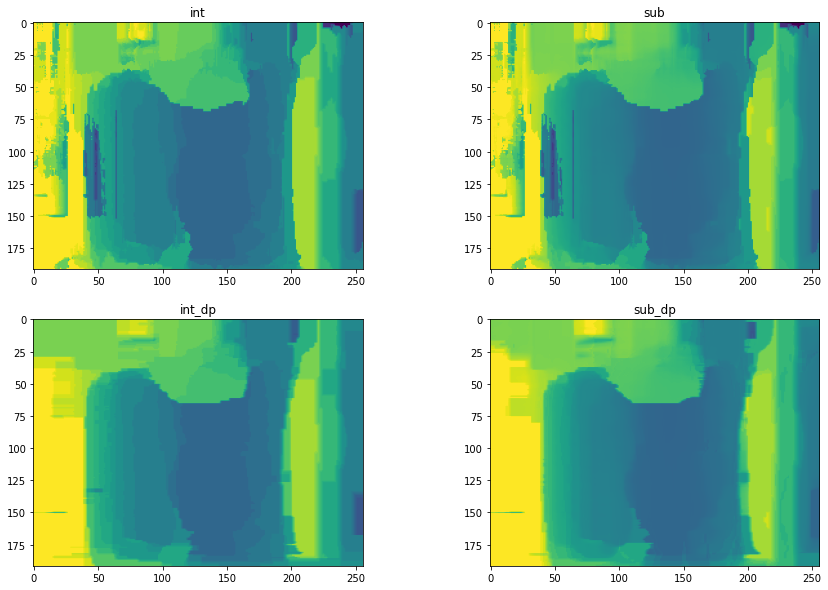

In [70]:
_, axs = plt.subplots(2, 2, figsize=(15,10))
for ax, rect_match, type_min_path in zip(axs.ravel(), rect_matchs, types_min_path): 
    ax.imshow(rect_match(arr1, arr2), vmin=-15, vmax=15)
    ax.set_title(type_min_path)

# Build

In [71]:
build_notebook()

<IPython.core.display.Javascript object>

Converted README.ipynb.


In [72]:
convert_notebook()

<IPython.core.display.Javascript object>